## 8x8 Sprite Scraper + Ripper
Scrapes 8x8 sprites from the web and saves them as a JSON file


### Setup
Imports and general functions

---

In [371]:
import requests
import time
import re
import os
import json
from bs4 import BeautifulSoup
import numpy as np
from urllib.parse import urljoin
from tqdm import tqdm
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
from matplotlib.colors import ListedColormap
import cv2
import colorsys

%matplotlib inline

In [15]:
# SETUP GENERAL SCRAPER FUNCTIONS

driver = None;

#retrieve the body content from a link
def getLinkSoup(link,wait_time=1):
    global driver
    if driver is None:
        driver = webdriver.Chrome(ChromeDriverManager().install())

    #check if it is a valid link first before running
    if not validLink(link):
        return None
    
    driver.get(link)
    time.sleep(wait_time) #if you want to wait 1 seconds for the page to load
    response = driver.page_source
    soup = BeautifulSoup(response, 'html.parser')
    return soup

#retrieve the body content from a link without using selenium
def quickLinkSoup(link):
    response = requests.get(
        url=link,
        headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    )
    if response.status_code != 200:
        print(f"> ERROR: Link [{link}] not found... (Response: {response.status_code})")
        return None
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

# retrieve the body content from a link with cookies and headers
def soupWithHeaderCookies(link,cookies,headers):
    response = requests.get(
        url=link,
        headers = headers,
        cookies = cookies
    )
    if response.status_code != 200:
        print(f"> ERROR: Link [{link}] not found... (Response: {response.status_code})")
        return None
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup


#check if the link is valid
def validLink(link):
    response = requests.get(
        url=link,
        headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    )
    if response.status_code != 200:
        print(f"> ERROR: Link [{link}] not found... (Response: {response.status_code})")
        return False
    else:
        return True


In [49]:
# EXPORTING FUNCTIONS

# export the data to a json file
'''
    JSON FORMAT per item:
    {
        "name": "[SPRITE_NAME]",
        "palette": ['#hex','#hex', ...],
        "sq_size": 8,
        "data": "a63c010073b1ade526..."  #size^2 max hex values
    }

'''
def exportDatJSON(dat,palette,size,filename):
    sprite_data = {"palette":palette,"size":size,"sprite_dat":dat}
    with open(filename, 'w+') as outfile:
        json.dump(sprite_data, outfile, indent=3)


# imports the data from a json file as a dictionary
# reverse of above function
def importJSON(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data


### Scrape + Rip Data - OMW to steal yo data heheheh
---

#### Nerdy Teachers PICO-8 Sprites
They kinda suck but at least they're free and named

In [17]:
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']
NERD_TEACHER_SPRITE_LINK = "https://nerdyteachers.com/PICO-8/Sprites/"

nerd_cookies = {
    'PHPSESSID': 'jb8dhfio2niu9595rv5o9qs0ng',
    '_gid': 'GA1.2.290876285.1677532772',
    'trustedsite_visit': '1',
    'G_ENABLED_IDPS': 'google',
    '_ga_4402QF0WFM': 'GS1.1.1677534934.2.1.1677537183.0.0.0',
    '_ga': 'GA1.2.1266327957.1677532769',
}

nerd_headers = {
    'authority': 'nerdyteachers.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    # 'cookie': 'PHPSESSID=jb8dhfio2niu9595rv5o9qs0ng; _gid=GA1.2.290876285.1677532772; trustedsite_visit=1; G_ENABLED_IDPS=google; _ga_4402QF0WFM=GS1.1.1677534934.2.1.1677537183.0.0.0; _ga=GA1.2.1266327957.1677532769',
    'referer': 'https://nerdyteachers.com/PICO-8/Sprites/library.php?k=&size=8x8&x=32&y=55',
    'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Google Chrome";v="108"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
}

# use this: https://stackoverflow.com/questions/65689272/scraping-website-with-beautiful-soup-that-requires-login

nerd_soup = soupWithHeaderCookies(NERD_TEACHER_SPRITE_LINK,nerd_cookies,nerd_headers)

In [50]:
# extract the name and text data from a nerd link's button
def getNerdPicoDat(link):
    soup = soupWithHeaderCookies(link,nerd_cookies,nerd_headers)
    if soup is None:
        print("ERROR: No soup for you!")
        return None
    
    spr_a = soup.find_all("a",{"class":"nerdyButton galleryLink"})                       #get all the links
    spr_a_8 = list(filter(lambda a: a.get('title') and "8x8" in a.get('title'), spr_a))  #remove all links that aren't 8x8 in title
    spr_a_8_onclick = [a["onclick"] for a in spr_a_8]                                    #get the onclick attribute                    

    #split on the comma and get the second and third elements and create as an item
    spr_ocs = [a.split(",") for a in spr_a_8_onclick]
    spr_dat = [{"name":a[1].replace("'",""),"dat":a[2].replace("-","")} for a in spr_ocs]

    return spr_dat;

# demo = getNerdPicoDat("https://nerdyteachers.com/PICO-8/Sprites/library.php?k=famous")
# print(demo)

In [51]:
# easier to just list all of the links here rather than searching (not too many anyways)
ALL_NERD_LINKS = [
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=famous",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=1bit",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=icons",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=people",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=animals",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=plants",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=monsters",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=items",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=weapons",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=armor",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=decor",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=food",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=scenery",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=vehicles",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=particles",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=buildings",
    "https://nerdyteachers.com/PICO-8/Sprites/library.php?k=other"
]

# get all the sprites from the nerd teacher site
nerd_dat = []

for link in ALL_NERD_LINKS:
    d = getNerdPicoDat(link)
    nerd_dat += d

    print(f'Found {len(d)} sprites from {link.split("?k=")[1]} - NERD SITE')

print(f'Found {len(nerd_dat)} sprites from NERD SITE')

#export output
exportDatJSON(nerd_dat,PICO_PALETTE,8,"../data/sprite_data/nerd_sprites.json")


Found 35 sprites from famous - NERD SITE
Found 27 sprites from 1bit - NERD SITE
Found 33 sprites from icons - NERD SITE
Found 81 sprites from people - NERD SITE
Found 57 sprites from animals - NERD SITE
Found 30 sprites from plants - NERD SITE
Found 22 sprites from monsters - NERD SITE
Found 25 sprites from items - NERD SITE
Found 15 sprites from weapons - NERD SITE
Found 27 sprites from armor - NERD SITE
Found 17 sprites from decor - NERD SITE
Found 56 sprites from food - NERD SITE
Found 25 sprites from scenery - NERD SITE
Found 13 sprites from vehicles - NERD SITE
Found 4 sprites from particles - NERD SITE
Found 12 sprites from buildings - NERD SITE
Found 53 sprites from other - NERD SITE
Found 532 sprites from NERD SITE


#### Image ripper
Takes sprites from images (on Twitter)

In [220]:
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']

def rgb2hex(r,g,b):
    return f"#{r:02x}{g:02x}{b:02x}".upper()

def hex2rgb(hex):
    h2 = hex.lstrip('#')
    return tuple(int(h2[i:i+2], 16) for i in (0, 2, 4))

# gets the closest color based on euclidean distance in RGB space
def closestColor(hex,palette=PICO_PALETTE):
    r,g,b = hex2rgb(hex)
    d = [np.linalg.norm(np.array([r,g,b]) - np.array(hex2rgb(p))) for p in palette]
    return d.index(min(d))

# reads in a sprite sheet and converts to an integer format based on the palette
def readSpriteSheet(filename,palette=PICO_PALETTE):
    img = Image.open(filename)
    pixels = img.load() 
    width, height = img.size

    int_img = []
    for y in range(height):
        row = []
        for x in range(width):
            r, g, b = pixels[x,y]
            hex = rgb2hex(r,g,b)
            if palette and hex in palette:
                val = palette.index(hex)
            else:  # if not in palette, find the closest match in the palette based on euclidean distance
                val = closestColor(hex,palette)
            row.append(val)
        int_img.append(row)
    
    return int_img


# get all the sprites from the sprite sheet
int_pico_char = readSpriteSheet("../data/rip_data/pico_characters.png")
int_pico_food = readSpriteSheet("../data/rip_data/pico_food.png")

In [221]:
# breaks up the sprite sheet into 8x8 sprites
def getSprites(sheet,size=8,pad=2):
    sprites = []
    sheet_n = np.array(sheet)
    si = size+pad*2
    sx = len(sheet)//si
    sy = len(sheet[0])//si
    for x in range(sx): 
        for y in range(sy):
            offx = x*si+pad
            offy = y*si+pad
            sprite = sheet_n[offx:offx+size,offy:offy+size]
            # print(sprite.shape)
            sprites.append(sprite)
    return sprites

# get all the sprites from the sprite sheet
pico_char_sprs = getSprites(int_pico_char)
pico_food_sprs = getSprites(int_pico_food)

In [222]:
# turn into colormap for matplotlib
pico_map = ListedColormap(PICO_PALETTE,N=len(PICO_PALETTE))

# show a sprite in the jupyter notebook
def showSprite(spr,palette=PICO_PALETTE):
    colormap = ListedColormap(palette,N=len(palette))

    plt.axis('off')
    plt.imshow(spr.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
    plt.show()


#show the binary, colors, then combined for a 2d image
def showMultiSprites(sprs,palette=PICO_PALETTE,text='',textArr=None):
    colormap = ListedColormap(palette,N=len(palette))

    #show sprites
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(sprs):
        plt.subplot(int(len(sprs) / col) + 1, col, i + 1)
        plt.imshow(im.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
        plt.axis('off')

        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(sprs),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(sprs),col)//2):
                plt.title(text.upper())
    plt.show()

[[ 0  0 11 11 10 10  9  0]
 [ 0  7 11 10 15 10 10  9]
 [ 3  7 15 10  0 15  0  0]
 [ 0  7  0 15 15 15 15  0]
 [ 0  7 11 11 15  3  0  6]
 [12 12 12  4  9  4  3 13]
 [ 0 15  3 11 11  3  0 13]
 [ 0  0  4  0  0  2  0  0]]


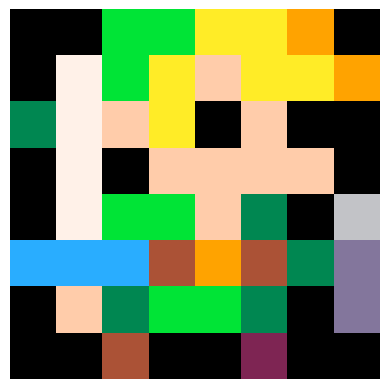

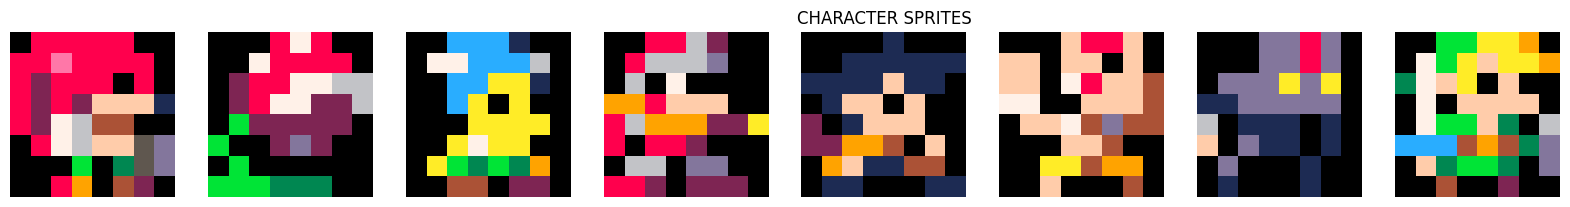

In [223]:
# show sample sprites
cspr = random.choice(pico_char_sprs)
print(cspr)
showSprite(cspr)
showMultiSprites(random.sample(pico_char_sprs,k=8),text='CHARACTER SPRITES')

[[ 0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0 11 11  0]
 [ 0  0  0  0  8  8  8  0]
 [ 0  0  0  8 14  8  8  0]
 [ 0  0  8 14  8  8  2  0]
 [ 8  8  8  8  8  2  0  0]
 [ 0  2  2  2  2  0  0  0]]


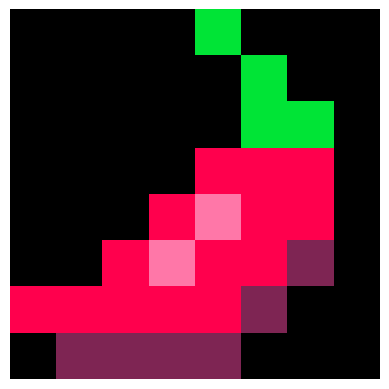

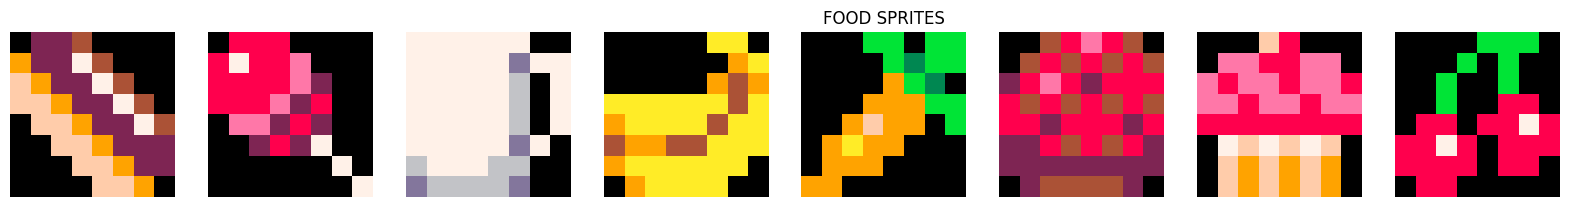

In [228]:
# show sample sprites
fspr = random.choice(pico_food_sprs)
print(fspr)
showSprite(fspr)
showMultiSprites(random.sample(pico_food_sprs,k=8),text='FOOD SPRITES')

#### ICON DATASET DOWNSCALE - No Rip - only downscale
Use the [Icon645](https://iconqa.github.io/) and [Icons-50](https://www.kaggle.com/datasets/danhendrycks/icons50) labeled image dataset and try to convert to PICO-8 8X8 pixel art

In [151]:
'''

ICONS-50 DEFINTIION OF KEYS:
    rendition: version of the sprite
    image: the sprite itself as 32x32x3 values
    style: where it came from (microsoft, apple, google, etc)
    class: index in the CLASS list 
    subtype: image label - more specific


'''

# import the icons-50 dataset: 50 classes for 10k samples of 32x32 emojis/icons
icons50 = np.load('../data/rip_data/Icons-50.npy', allow_pickle=True).item()
icons50_classes = ["airplane","arrow_directions","ball","biking","bird","blade","boat","books","building","bunny_ears","cartwheeling","clock","cloud","disk","drinks","emotion_face","envelope","family","fast_train","feline","flag","flower","footwear","golfing","hand","hat","heart","holding_hands","japanese_ideograph","kiss","lock","mailbox","marine_animals","medal","money","monkey","moon","mountain","numbers","phone","prohibit_sign","star","surfing","tree","umbrella","vehicle","water_polo","worker","wrestling","writing_utensil"]

ICON_CLASSES = [icons50_classes[i].replace("_"," ") for i in icons50['class']]
ICON_LABELS = [i.replace("_"," ") for i in icons50['subtype']]
ICON_IMGS = [i.transpose(1,2,0) for i in icons50['image']]

def showIcon(ic,label=None):
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(ic)
    if label:
        plt.title(label.upper())
    plt.show()

def showMultiIcons(ics,text='',textArr=[]):
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(ics):
        plt.subplot(int(len(ics) / col) + 1, col, i + 1)
        plt.imshow(im)
        plt.axis('off')
        
        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(ics),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(ics),col)//2):
                plt.title(text.upper())

    plt.show()


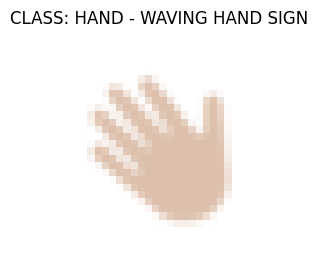

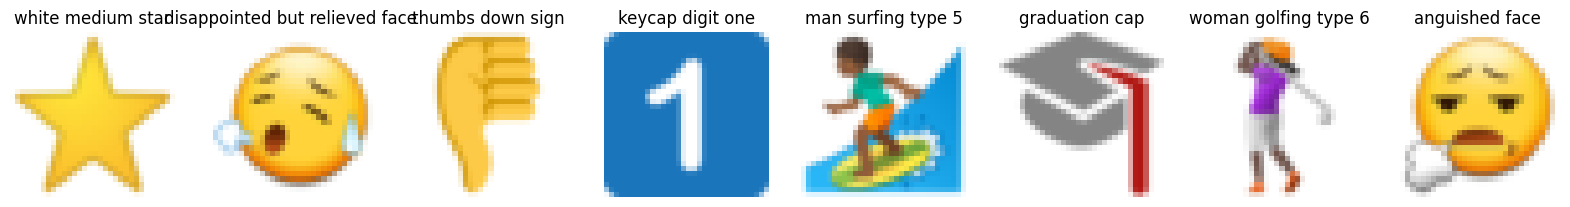

In [247]:
# show an example icon
ri = random.randint(0,len(ICON_CLASSES))
label = f"CLASS: {ICON_CLASSES[ri]} - {ICON_LABELS[ri]}"
showIcon(ICON_IMGS[ri],label=label)

# show a random sample of icons
ris = random.sample(list(range(len(ICON_CLASSES))),k=8)
showMultiIcons([ICON_IMGS[i] for i in ris],textArr=[ICON_LABELS[i] for i in ris])


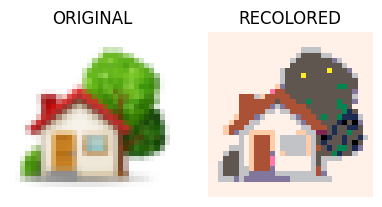

In [294]:
# RE-COLORING TESTS

# recolor the icons to match the pico-8 palette; assume input is NxNx3 array
def recolorIcon(ic,palette=PICO_PALETTE):
    ic2 = np.zeros(ic.shape[:2],dtype=np.int32)
    for x,y in np.ndindex(ic.shape[:2]):
        r,g,b = ic[x,y]
        hex = rgb2hex(r,g,b)
        if hex in palette:
            ic2[x,y] = palette.index(hex)
        else:
            ic2[x,y] = closestColor(hex,palette)

    #convert back to rgb
    ic3 = np.array([hex2rgb(palette[i]) for i in ic2.flatten()]).reshape(ic.shape[:2]+(3,))

    return ic3

#test and show
si = 5556  #6597, 3722, 7372, 5556
ic = ICON_IMGS[si]
new_ic = recolorIcon(ic,palette=PICO_PALETTE)

showMultiIcons([ic,new_ic],textArr=['ORIGINAL','RECOLORED'])

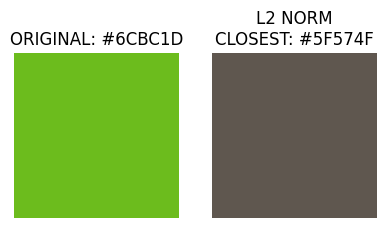

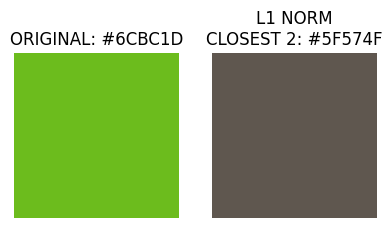

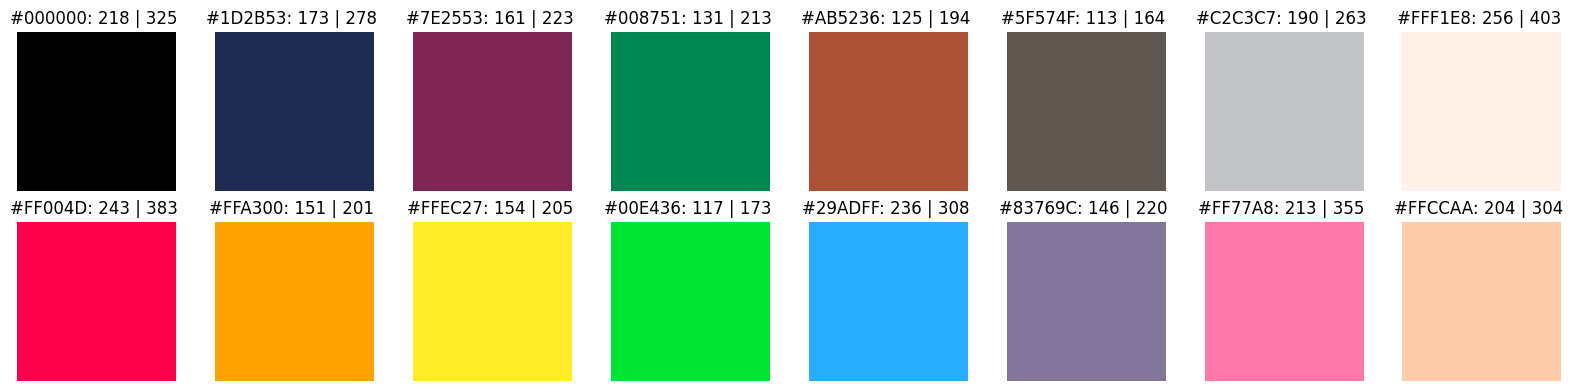

In [336]:
# make sure colors are correct

c1_rgb = ic[7,20]
# c1_rgb = ic[0,0]
c1_hex = rgb2hex(*c1_rgb)
# c1_hex = "#ff0000"
# c1_rgb = list(hex2rgb(c1_hex))
c2_hex = PICO_PALETTE[closestColor(c1_hex,PICO_PALETTE)]
c2_rgb = list(hex2rgb(c2_hex))

c1_grid = np.array([c1_rgb for i in range(4)]).reshape(2,2,3)
c2_grid = np.array([c2_rgb for i in range(4)]).reshape(2,2,3)

p_d = [np.linalg.norm(c1_rgb - hex2rgb(p)) for p in PICO_PALETTE]    #l2 norm
p_d2 = [sum(abs(np.subtract(c1_rgb,list(hex2rgb(p))))) for p in PICO_PALETTE]      #l1 norm
p_grid = []
for p in PICO_PALETTE:
    p_grid.append(np.array([hex2rgb(p) for i in range(4)]).reshape(2,2,3))

#l2 norm
showMultiIcons([c1_grid,c2_grid],textArr=[f'ORIGINAL: {c1_hex}',f'CLOSEST: {c2_hex}'],text='l2 norm')

#l1 norm
p_close = np.argmin(p_d)
showMultiIcons([c1_grid, p_grid[p_close]],textArr=[f'ORIGINAL: {c1_hex}',f'CLOSEST 2: {PICO_PALETTE[p_close]}'], text='l1 norm')

#show all distances
showMultiIcons(p_grid,textArr=[f"{PICO_PALETTE[i]}: {int(p_d[i])} | {int(p_d2[i])} " for i in range(len(PICO_PALETTE))])



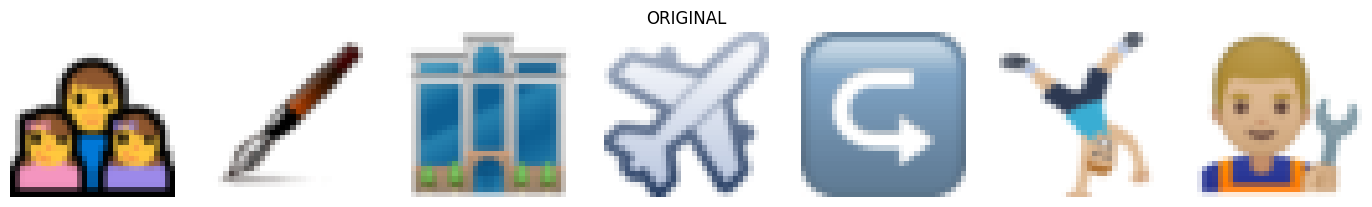

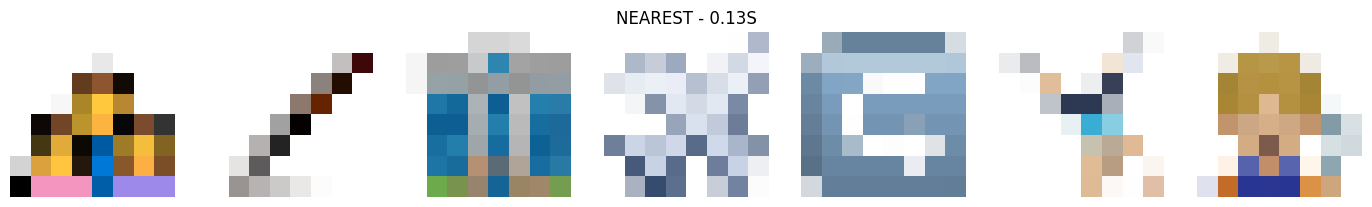

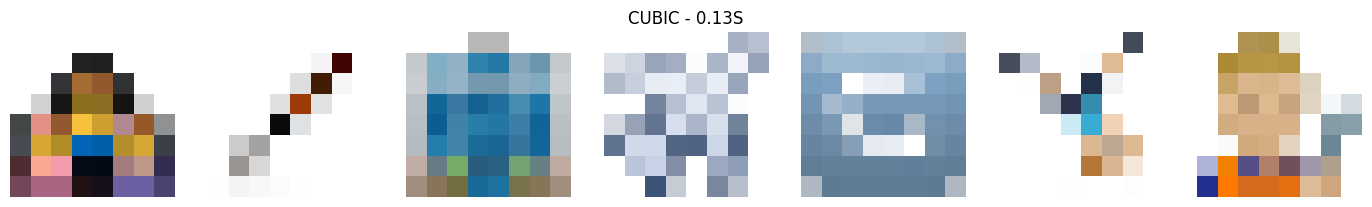

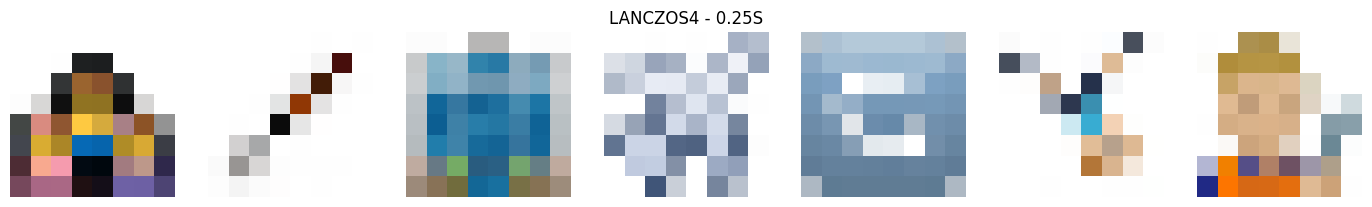

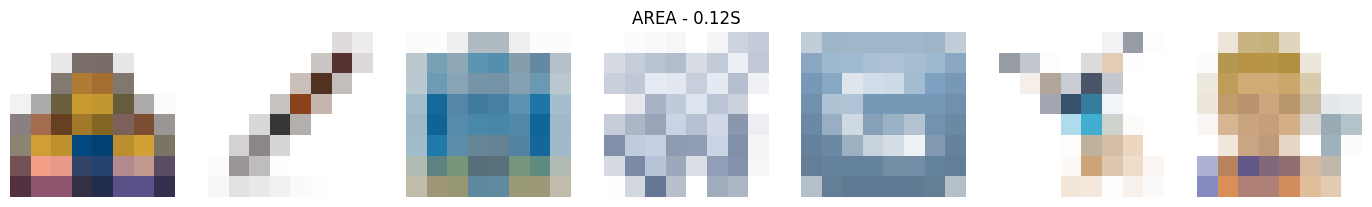

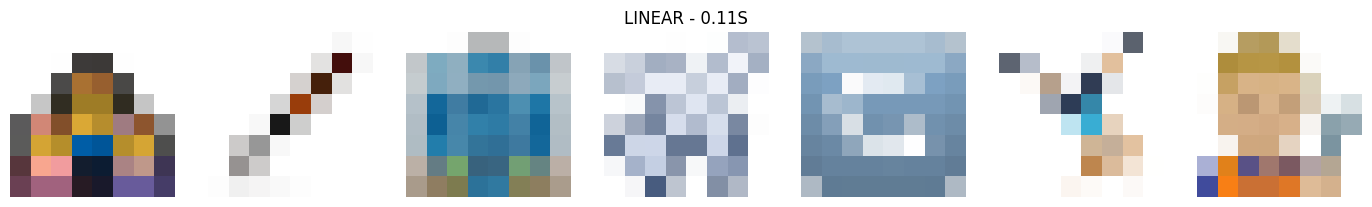

In [348]:
# DOWNSAMPLE ICONS TO 8x8
# NOTE: CUBIC AND LANCZOS4 ARE THE BEST - BUT CUBIC IS TWICE AS FAST WITH NEARLY IDENTICAL OUTPUT
# IN SOME CASES, NEAREST NEIGHBOR IS BETTER THAN CUBIC WITH PARTICULAR SHAPES AND TRANSPARENCIES; BUT WITH LESS SYMMETRY
# TRAIN ON BOTH? 

# open-cv downsample
ris = random.sample(list(range(len(ICON_CLASSES))),k=7)
showMultiIcons([ICON_IMGS[i] for i in ris],text='original')

inter_set = {"nearest":cv2.INTER_NEAREST, "cubic":cv2.INTER_CUBIC, "lanczos4":cv2.INTER_LANCZOS4, "area":cv2.INTER_AREA, "linear":cv2.INTER_LINEAR}
for k, inter in inter_set.items():
    start_time  = time.time()
    DOWN_ICON_IMGS = [cv2.resize(i,(8,8),interpolation=inter) for i in ICON_IMGS]
    end_time = time.time()
    showMultiIcons([DOWN_ICON_IMGS[i] for i in ris],text=f"{k} - {(end_time - start_time):.2f}s")

#donwsample an image
def pixel8(im,inter='linear'):
    return cv2.resize(im,(8,8),interpolation=(cv2.INTER_NEAREST if inter == "linear" else cv2.INTER_CUBIC))


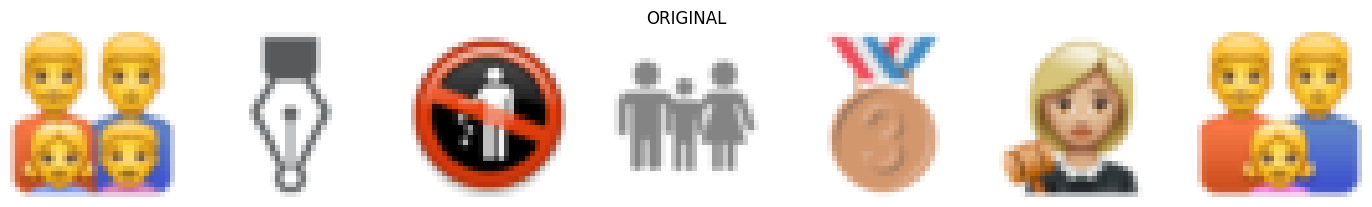

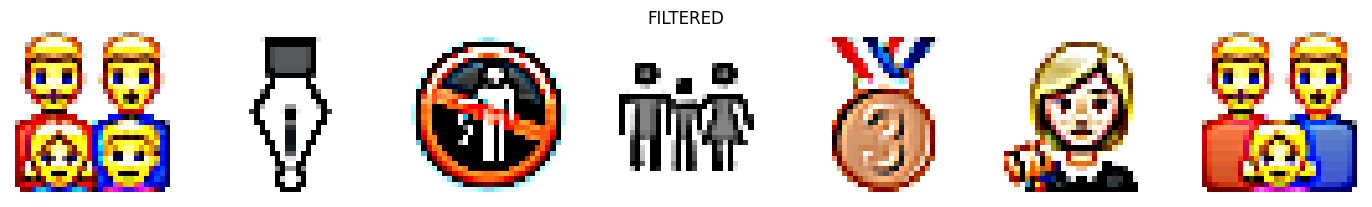

In [350]:
# SHARPEN IMAGES using KERNELS
# TOO DEEP-FRIED

identity = np.array([[0,0,0], [0,1,0], [0,0,0]])
kernel5 = np.array([[-1,-1,-1], [-1,5,-1], [-1,-1,-1]])
kernel9 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

ris = random.sample(list(range(len(ICON_CLASSES))),k=7)
showMultiIcons([ICON_IMGS[i] for i in ris],text='original')
showMultiIcons([cv2.filter2D(ICON_IMGS[i], -1, kernel9) for i in ris],text='filtered')



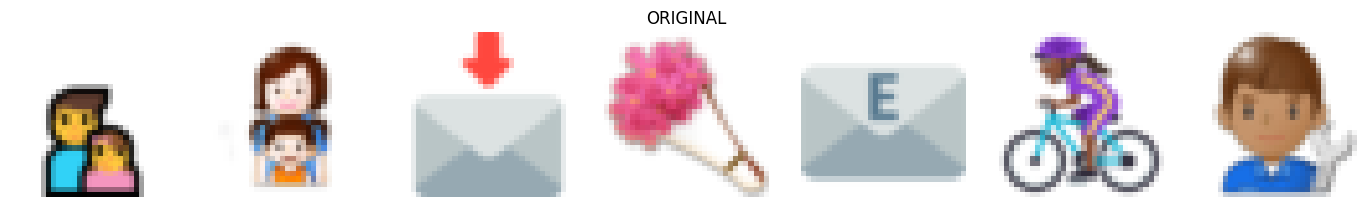

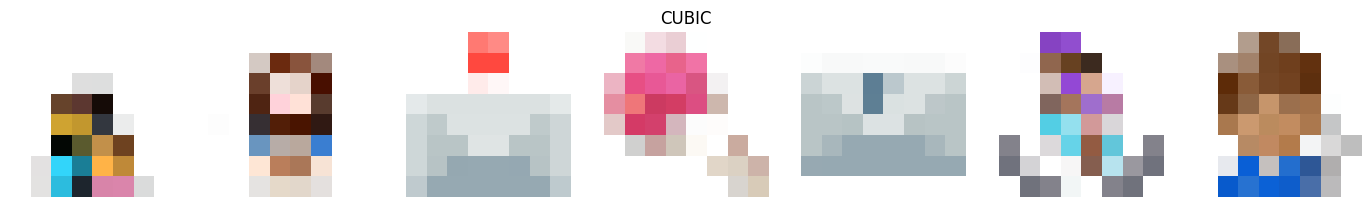

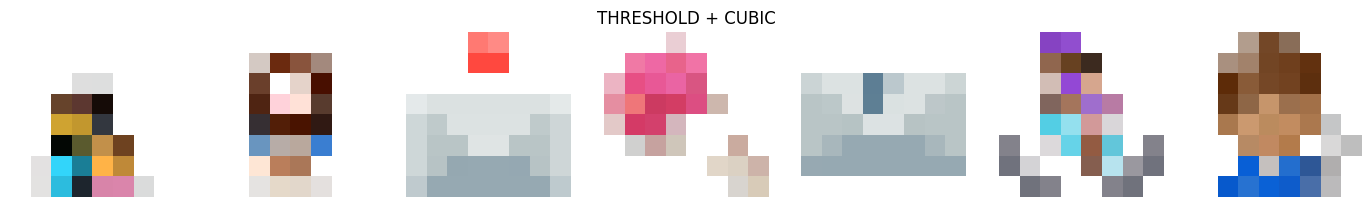

In [479]:
# SHARPEN BASED ON THRESHOLD VALUES
# JUST RIGHT - MISSES A FEW STRAY PIXELS BUT 0.92 SEEMS TO BE THE BEST

# convert color integer value to decimal
def colDec(v):
    return v/255

# strengthens the saturation of a color by modifying the saturation component and lightness
def strongColor(r,g,b):
    #convert to hsv
    h,s,v = colorsys.rgb_to_hsv(r/255,g/255,b/255)

    #too white - return pure white
    if v > 0.92 and s < 0.15:    #0.93, 0.06
        return [255,255,255]
    #grayscale - return as is
    elif h == 0 or s < 0.9:
        return [r,g,b]
    #otherwise modify saturation
    else:
        r2,g2,b2 = colorsys.hsv_to_rgb(h,s if s > 0.15 else 0,v)
        return [int(r2*255),int(g2*255),int(b2*255)]

# change pixels to white if above threshold
def sharp_thresh(img,thresh=0.92):
    tv = thresh*255
    img2 = np.zeros(img.shape,dtype=np.int32)
    for x,y in np.ndindex(img.shape[:2]):
        r,g,b = img[x,y]
        # convert color
        img2[x,y] = strongColor(r,g,b)
    return img2


ris = random.sample(list(range(len(ICON_CLASSES))),k=7)
rand_imgs = [ICON_IMGS[i] for i in ris]
# thresh_imgs = [sharp_thresh(i) for i in rand_imgs]


showMultiIcons(rand_imgs,text='original')
# showMultiIcons(thresh_imgs,text='threshold')
showMultiIcons([pixel8(j,'cubic') for j in rand_imgs],text='cubic')
showMultiIcons([sharp_thresh(i) for i in [pixel8(j,'cubic') for j in rand_imgs]],text='threshold + cubic')
# showMultiIcons([pixel8(j,'linear') for j in rand_imgs],text='linear')
# showMultiIcons([sharp_thresh(i) for i in [pixel8(j,'linear') for j in rand_imgs]],text='threshold + linear')


(0.28472222222222215, 0.09917355371900827, 0.9490196078431372)
[156, 242, 121]


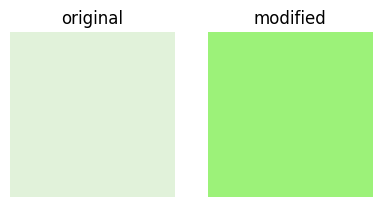

In [436]:
c = [225,242,218]
add_color = 0.4
c2 = colorsys.rgb_to_hsv(c[0]/255,c[1]/255,c[2]/255)
c3 = colorsys.hsv_to_rgb(c2[0],c2[1]+add_color,c2[2])
c3 = [int(c3[0]*255),int(c3[1]*255),int(c3[2]*255)]

c1_grid = np.array([c for i in range(4)]).reshape(2,2,3)
c3_grid = np.array([c3 for i in range(4)]).reshape(2,2,3)

print(c2)
print(c3)

showMultiIcons([c1_grid,c3_grid],textArr=['original','modified'])


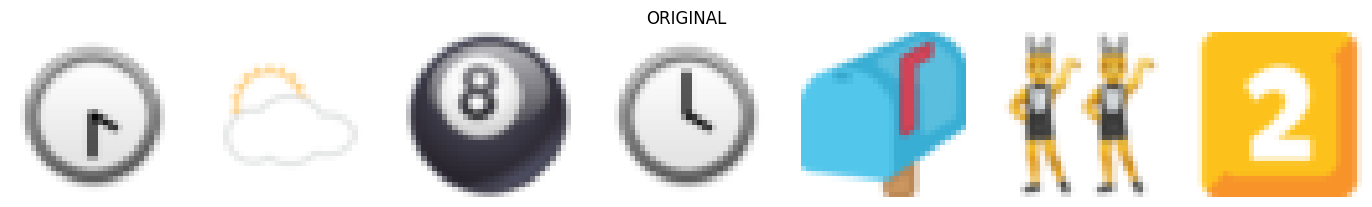

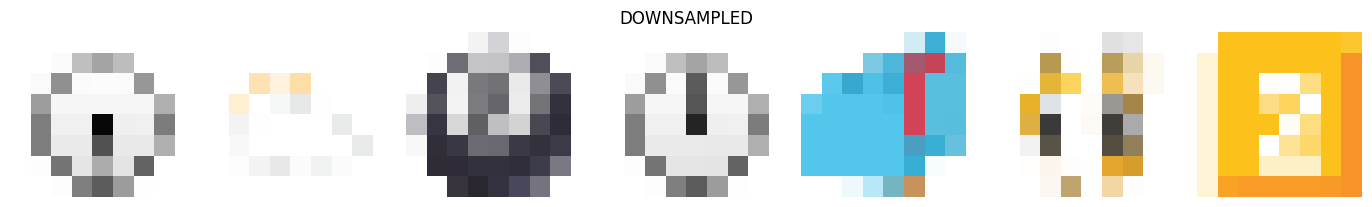

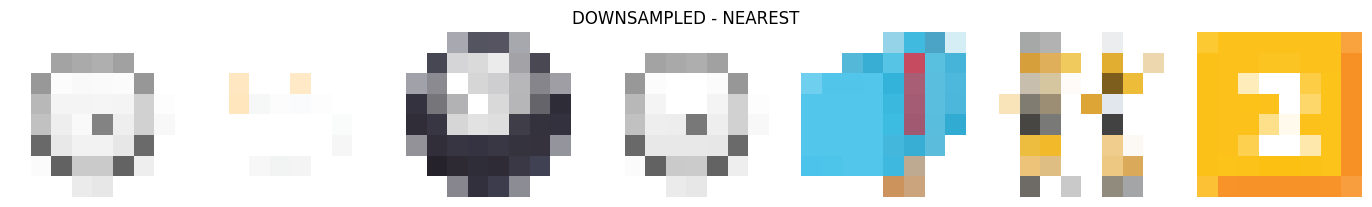

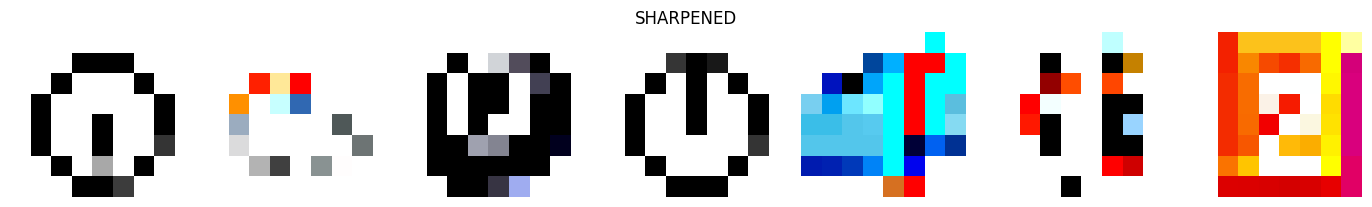

In [351]:
# downsample and resize
ris = random.sample(list(range(len(ICON_CLASSES))),k=7)
img_org = [ICON_IMGS[i] for i in ris]
img_ds = [pixel8(i) for i in img_org]
img_ds2 = [pixel8(i,inter='nearest') for i in img_org]
img_sharp = [sharpen(i) for i in img_ds]
showMultiIcons(img_org,text='original')
showMultiIcons(img_ds,text='downsampled')
showMultiIcons(img_ds2,text='downsampled - nearest')
showMultiIcons(img_sharp,text='sharpened')

#### PICO-8 BBS + Ripper + Spritesheet slicer tool
Takes cartridges from the BBS (p8dl: https://github.com/franciscod/p8dl) then extracts spritesheets from them (picoknife: https://github.com/rtouk/picoknife) and slices the images into 8x8 chunks ()